## Decision Tree: Branch Analyses

1. Reporting Year (Year 0 - baseline)
2. TTC Tree cover
3. Land Use
4. Strategy
5. Imagery or site accessibility

### General Notes
- inactive projects include: africorp-intl, divine-bamboo-group, germark, poel, s3d-niger (7 total in cohort 1)

### Decisions
- An "open" or "closed" designation was assigned at the project level based on the proportion of sites that fell the into open/closed category.
- Project names that did not align were dropped.
- ttc NA - sites without TTC % were dropped. This occurs due to missing TTC tiles, eventually we will have data. 
- Sites where planting occurs in 2025 were dropped. TODO: Check the other sites in the prj.
- What does imagery % represent and what is a workable threshold? Does it represent coverage for the polygon or wider AOI?
- plant_start - date that planting is started is available by site, so would have to aggregate for a project. Does it make sense to do the first date of planting?

Polygons:  
- when merging ttc and ft_polys using 3 keys - project name, site name and polygon name - there are some duplicates. It seems all values are the same except the slope and aspect stats. Not using these columns for now so dropping.

**Notes on datasets**
- `target_sys` in ttc refers to the current land use (used for error calcs)
- Can I assume that any LU that is not in 'direct_seeding', 'tree_planting', 'assisted_natural_regeneration', is a type of ANR?

**Questions**
- plantstart date looks like it's a feature of each poly metadata. Is it the same as the ttc plantstart date?

In [4]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

# Check alignment

In [80]:
# new polygon data as of 8/14/24
shp = gpd.read_file("../data/all_projects_TM_081424")
ttc_raw = pd.read_excel('../data/ttc_baseline_062024.xlsx')
ft_poly = pd.read_csv('../data/features_polygon_071824.csv')
shp.shape, ttc_raw.shape, ft_poly.shape

((13017, 7), (11670, 19), (13055, 11))

In [81]:
shp.shape[0] - ft_poly.shape[0]

-38

In [82]:
shp_prjlist = list(set(shp.Project))
ft_prjlist = list(set(ft_poly.Project))
shp_polylist = list(set(shp.poly_name))
ft_polylist = list(set(ft_poly.poly_name))
shp_sitelist = list(set(shp.SiteName))
ft_sitelist = list(set(ft_poly.SiteName))
diff_prj = [i for i in ft_prjlist if i not in shp_prjlist]
diff_poly = [i for i in ft_polylist if i not in shp_polylist]
diff_site = [i for i in ft_sitelist if i not in shp_sitelist]

diff_prj, diff_poly, diff_site

(['nguni'],
 ['koko Regeneration site', 'Reforestation Project\xa010'],
 ['Bbambula',
  'Reforestation Project\xa0',
  'Main_Gate',
  'koko Regeneration site',
  'Namwene',
  'Kikandwa'])

In [83]:
site_df = ft_poly[ft_poly.SiteName.isin(['Bbambula',
                              'Reforestation Project\xa0',
                              'Main_Gate',
                              'koko Regeneration site',
                              'Namwene',
                              'Kikandwa'])]
site_df.shape

(54, 11)

In [84]:
# update ft_poly with new target sys and practice values
ft_poly.rename(columns={'target_sys':'target_sys_og',
                     'practice':'practice_og'}, inplace=True)

ft_poly_new = pd.merge(ft_poly, 
                     shp[['Project', 'SiteName', 'poly_name','target_sys', 'practice']], 
                     how='inner', on=['Project', 'SiteName', 'poly_name'])
ft_poly_new = ft_poly_new.drop_duplicates()
ft_poly_new.shape

(13035, 13)

In [85]:
ft_poly.shape[0] - ft_poly_new.shape[0]

20

In [88]:
# there are still some dups, likely bc of slope and aspect
columns_to_match = ['project', 'sitename', 'poly_name', 'plantstart', 'area_ha']
dups = ft_poly_new.duplicated(subset=columns_to_match, keep=False)
display(dups.value_counts())
ft_poly_new = ft_poly_new.drop_duplicates(subset=columns_to_match)
ft_poly_new.shape

False    10981
True      2054
Name: count, dtype: int64

(11877, 13)

## Clean TTC

In [86]:
# clean ttc
ft_poly_new.columns = ft_poly_new.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
to_keep = ['Percent Tree Cover 2020', 'Project', 'SiteName', 'poly_name']
drop_cols = [col for col in ttc_raw.columns if col not in to_keep]
ttc = ttc_raw[to_keep]
ttc.columns = ttc.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
ttc = ttc.rename(columns={'percent_tree_cover_2020': 'ttc'})
print(f"Dropping {len(ttc[ttc['ttc'] == 'TTC_NA'])} null values for TTC")
ttc = ttc[ttc['ttc'] != 'TTC_NA']
ttc['ttc'] = ttc['ttc'].astype('float')
ttc['ttc'] = ttc['ttc'].round()
print(ttc['ttc'].min(), ttc['ttc'].max())

Dropping 221 null values for TTC
0.0 100.0


In [87]:
def classify_canopy(project):
    closed_canopy = (project['ttc'] > 40).sum()
    open_canopy = (project['ttc'] <= 40).sum()
    return 'open' if open_canopy > closed_canopy else 'closed'

# .transform() method in pandas is used to apply a function to a group or subset of a df and 
# return an aligned result, meaning the output has the same shape as the input.
ttc['canopy'] = ttc.groupby('project')['ttc'].transform(lambda x: classify_canopy(ttc[ttc['project'] == x.name]))

print(f"Total sites <=40% cover: {len(ttc[ttc.ttc <= 40])}")
print(f"Total sites >40% cover: {len(ttc[ttc.ttc > 40])}")
print(ttc.canopy.value_counts())

Total sites <=40% cover: 7808
Total sites >40% cover: 3641
canopy
open      8552
closed    2897
Name: count, dtype: int64


# Combine

In [109]:
inter = pd.merge(ft_poly_new, ttc, on=['project', 'sitename', 'poly_name'])

In [110]:
inter.practice.value_counts()

practice
tree-planting                                                 10875
direct-seedling                                                 791
assisted-natural-regeneration                                   272
assisted-natural-regeneration,tree-planting,direct-seeding       92
assisted-natural-regeneration,tree-planting                      36
direct-seeding                                                    5
direct-seeding,tree-planting                                      4
direct-seeding,assisted-natural-regeneration                      4
tree-planting,assisted-natural-regeneration                       2
assisted-natural-regeneration,direct-seeding                      1
tree-planting,direct-seeding                                      1
Name: count, dtype: int64

In [113]:
inter['target_sys'] = inter['target_sys'].str.replace(r'\briparian-area-or-wetland\b', 'wetland', regex=True)
inter['target_sys'] = inter['target_sys'].str.replace(r'\briparian-or-wetland\b', 'wetland', regex=True)
inter['target_sys'] = inter['target_sys'].str.replace(r'\bwoodlot-or-plantation\b', 'plantation', regex=True)

inter['practice'] = inter['practice'].replace({
    'direct-seedling':'direct-seeding',
    'direct-seeding,tree-planting':'tree-planting,direct-seeding',
    'assisted-natural-regeneration,tree-planting':'tree-planting,assisted-natural-regeneration',
    'assisted-natural-regeneration,direct-seeding':'direct-seeding,assisted-natural-regeneration',
})

inter['practice'] = inter['practice'].str.replace(r'\bassisted-natural-regeneration\b', 'ANR', regex=True)

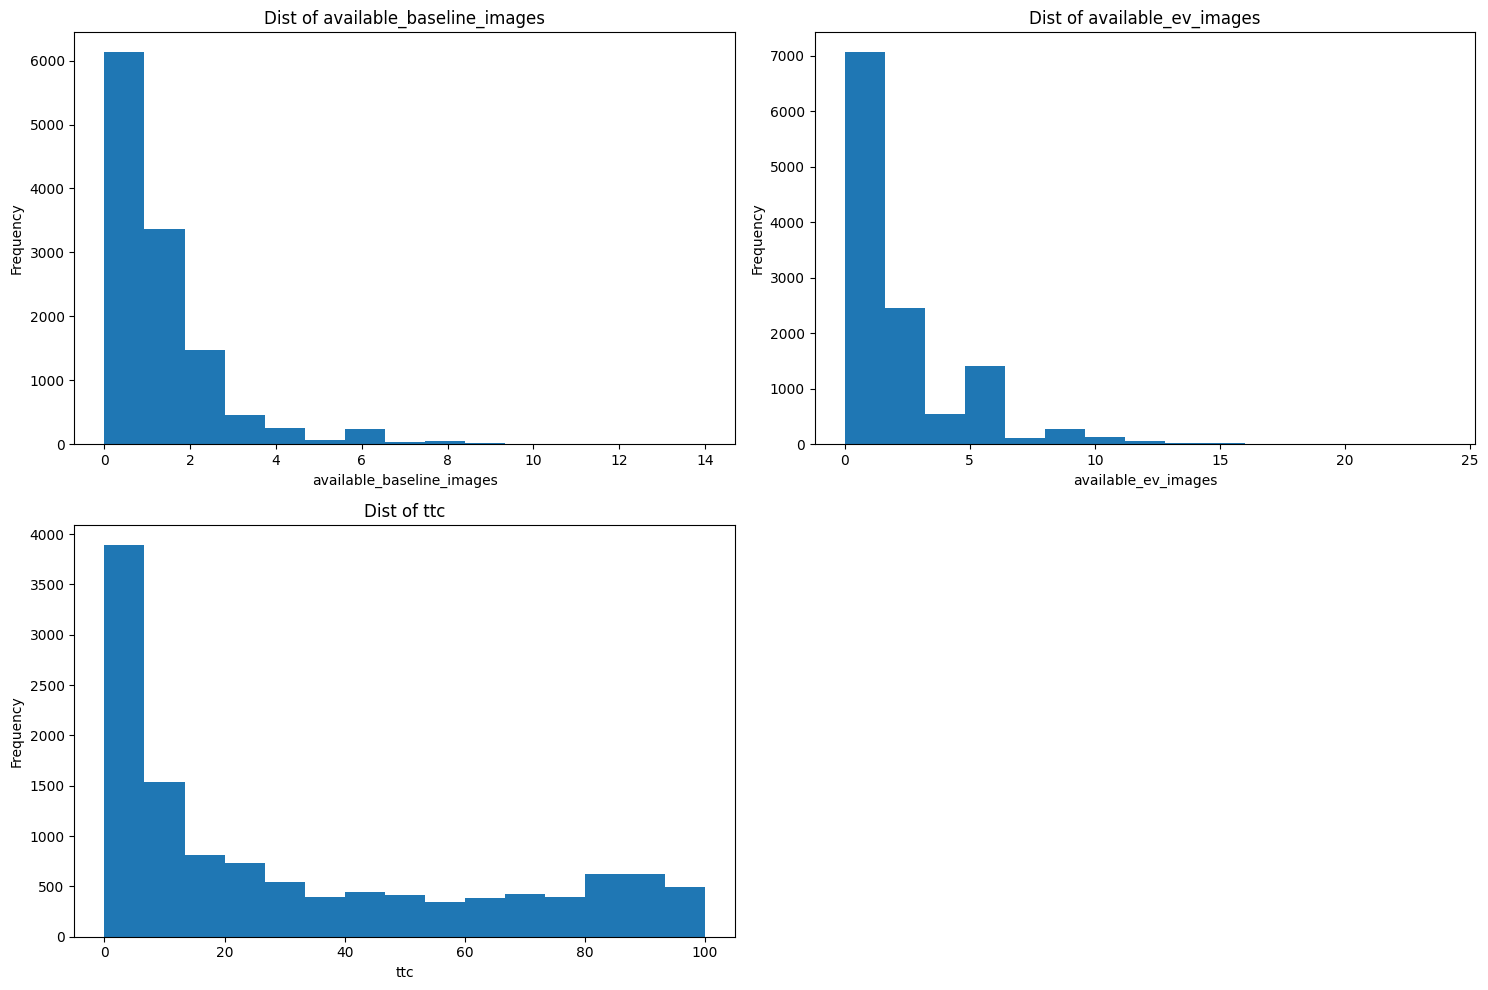

In [91]:
columns = ['available_baseline_images', 
          'available_ev_images',
          'ttc']
num_plots = len(columns)
fig, axes = plt.subplots(2, (num_plots // 2 + num_plots % 2), figsize=(15, 10))
axes = axes.flatten()
for i, col in enumerate(columns):
    inter[col].plot(kind='hist', bins=15, ax=axes[i], title=f'Dist of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
# Remove any empty subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()

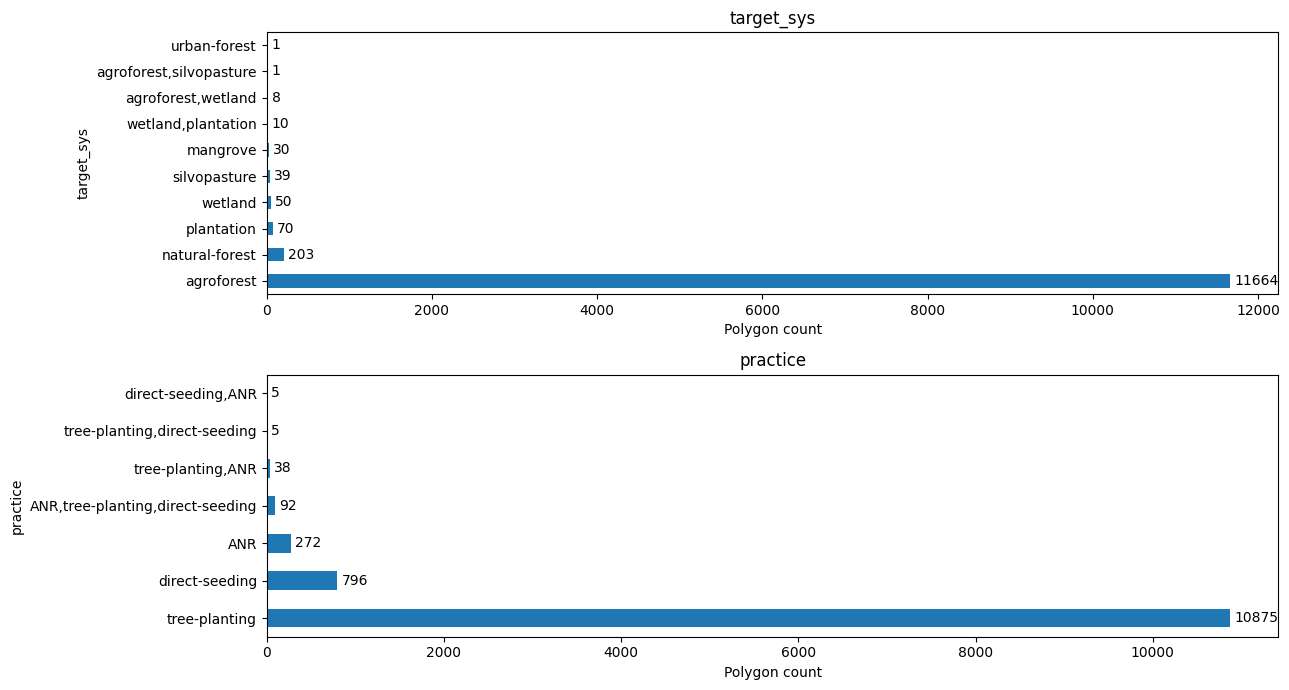

In [116]:
columns = ['target_sys', 'practice']
num_plots = len(columns)
fig, axes = plt.subplots(2, (num_plots // 2 + num_plots % 2), figsize=(13,7))
axes = axes.flatten()
for i, col in enumerate(columns):
    inter[col].value_counts().plot(kind='barh', ax=axes[i], title=f'{col}')
    axes[i].set_xlabel('Polygon count')
    axes[i].set_ylabel(col)
    for bars in axes[i].containers:
        axes[i].bar_label(bars,
                          label_type='edge', 
                          padding=3)
        
# Remove any empty subplots
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])
    

plt.tight_layout()

## Create Branches
1. Tree Cover: >40% (closed) or <40% (open)
2. Land Use: Agroforest, Natural Forest, Woodlot/Plantation, Riparian Area/Wetland, Silvopasture, Mangrove, Natural Ecosystem, Urban Forest, mix
3. Practice: ANR, direct seeing, tree planting, mix

In [118]:
inter.head()

,project,sitename,poly_name,plantstart,target_sys_og,practice_og,area_ha,available_baseline_images,available_ev_images,slope_stats,aspect_stats,target_sys,practice,ttc,canopy
0,addax-gum,Site de Plantation,Site de Plantation 1,2022-08-03,Null,Null,22.210348,0.0,2.0,"[{'min': 0.0, 'max': 11384.19921875, 'mean': 4...","[{'min': 0.0, 'max': 354.8055725097656, 'mean'...","agroforest,silvopasture","tree-planting,ANR",0.0,open
1,adhd,Agomaza/Deme/Goudeve/Lomnava,ESSESSI KOSSI RAPHAEL,2023-03-10,agroforest,Null,1.077154,1.0,0.0,"[{'min': 1272.792236328125, 'max': 14843.18066...","[{'min': 0.0, 'max': 353.6598205566406, 'mean'...",agroforest,tree-planting,5.0,open
2,adhd,Agomaza/Deme/Goudeve/Lomnava,AMENKO VALAIRE,2023-03-10,agroforest,Null,1.077154,1.0,0.0,"[{'min': 1423.02490234375, 'max': 5437.3706054...","[{'min': 18.434947967529297, 'max': 348.690063...",agroforest,tree-planting,12.0,open
3,adhd,Agomaza/Deme/Goudeve/Lomnava,BODJOA KOMLAN,2023-03-10,agroforest,Null,1.077141,1.0,0.0,"[{'min': 1909.1883544921875, 'max': 12870.3144...","[{'min': 0.0, 'max': 348.6900634765625, 'mean'...",agroforest,tree-planting,19.0,open
4,adhd,Agomaza/Deme/Goudeve/Lomnava,BODJOA ETSE,2023-03-10,agroforest,Null,1.077145,1.0,0.0,"[{'min': 636.3961181640625, 'max': 15286.75878...","[{'min': 5.710593223571777, 'max': 351.8699035...",agroforest,tree-planting,20.0,open


## Option 1: nested logic w/ custom function

In [120]:
def pseudocode(df):
    # branch 1
    open_canopy = df[df.canopy] == 'open'
    closed_canopy = df[df.canopy] == 'closed'
    
    # branch 2
    af = df[df.target_sys] == 'agroforest'
    forest = df[df.target_sys] == 'natural-forest'
    plantation = df[df.target_sys] == 'plantation'
    wetland = df[df.target_sys] == 'wetland'
    
    # branch 3
    tree_plant = df[df.practice] == 'tree-planting'
    anr = df[df.practice] == 'ANR'
    direct_seed = df[df.practice] == 'direct-seeding'

    ## i want to get all of the project, site and poly names that meet a series of different input critiera
    ## for example, which projects are open, plantation and tree planting?

In [ ]:
def testrun(df, canopy, target_sys, practice, year):
    '''
    Applies the input critera as each branch of the
    decision tree to reach a decision about the verification
    method.
    '''
    branch1 = df[df.canopy == canopy]
    branch2 = branch1[branch1.target_sys == target_sys]
    branch3 = branch2[branch2.practice == practice]
    
    if year == 'y0': 
        branch4 = branch3[branch3.available_baseline_images > 0]
    elif year == 'y3': 
        branch4 = branch3[branch3.available_ev_images > 0]
    if branch4.shape[0] == 0:
        df[branch4].assign(method='remote')
    else:
        df[branch4].assign(method='field')

    return df

In [ ]:
def exp(df, year, img_req):
    '''
    this option assigns a method to every row in the 
    input df - basically writes out the logic for 
    every possible option
    '''
    open_ = df[df.canopy == 'open']
    closed_ = df[df.canopy == 'closed']

    # agroforesty
    af_tp = open_[(open_.target_sys == 'agroforestry') & (open_.practice == 'tree-planting')]
    af_ds = open_[(open_.target_sys == 'agroforestry') & (open_.practice == 'direct-seeding')]
    af_anr = open_[(open_.target_sys == 'agroforestry') & (open_.practice == 'ANR')]
    
    

    

In [121]:
## Use a dictionary to define the decision tree and then apply to df

In [ ]:
### Write tests to confirm logic is working

### Legacy Code

### Imagery Branch

In [77]:
img_dir = '../data/imagery_availability/cohort1/'
imagery_files = os.listdir(img_dir)
imagery = []
for project in imagery_files:
    df = pd.read_csv(f"{img_dir}/{project}")
    sub_df = df[['Name', 
                 'properties.datetime',
                 'collection', 
                 'properties.eo:cloud_cover', 
                 'properties.off_nadir_avg']]
    sub_df = sub_df.assign(Project=project.replace('afr100_', '').replace('_imagery_availability.csv', ''))
    imagery.append(sub_df)
all_projects_df = pd.concat(imagery).reset_index()
all_projects_df = all_projects_df[['Project', 
                                   'Name', 
                                   'properties.datetime',
                                   'collection', 
                                   'properties.eo:cloud_cover',
                                   'properties.off_nadir_avg']]
all_projects_df = all_projects_df[~pd.isna(all_projects_df['Name'])]
all_projects_df.rename(columns={'Name':'poly_name'}, inplace=True)
all_projects_df.loc[:, 'properties.datetime'] = pd.to_datetime(all_projects_df['properties.datetime'], 
                                                               format='mixed').dt.normalize()
all_projects_df.loc[:, 'properties.datetime'] = all_projects_df['properties.datetime'].apply(lambda x: x.replace(tzinfo=None))

/var/folders/1v/8qs7l7157sddx1_9z9wqldrc0000gp/T/ipykernel_59671/842933163.py:5: DtypeWarning: Columns (73,74,75) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"{img_dir}/{project}")


In [78]:
all_projects_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147348 entries, 0 to 147347
Data columns (total 6 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Project                    147348 non-null  object 
 1   poly_name                  147348 non-null  object 
 2   properties.datetime        147348 non-null  object 
 3   collection                 147348 non-null  object 
 4   properties.eo:cloud_cover  147348 non-null  float64
 5   properties.off_nadir_avg   147348 non-null  float64
dtypes: float64(2), object(4)
memory usage: 6.7+ MB


In [85]:
# create a master csv of all projects for img availability, elevation and sun
img_dir = 'imagery_availability/cohort1/'
csv_list = listdir(img_dir)
csv_list = [re.split(r'_', file)[1] for file in csv_list if file.endswith('.csv')]
master_csv = pd.DataFrame()
for i in csv_list[0:1]:
    i = 'bccp'
    df = pd.read_csv(f'{img_dir}afr100_{i}_imagery_availability.csv')
    df = df[['id', 
             'collection', 
             'properties.datetime',
             'properties.eo:cloud_cover',
             'properties.collect_time_end',
             'properties.collect_time_start',
#              'properties.off_nadir_avg', 
#              'properties.off_nadir_end',
#              'properties.off_nadir_max', 
#              'properties.off_nadir_min',
#              'properties.view:sun_elevation_max',
#              'properties.view:sun_elevation_min',
            ]]
    dt_cols = ['properties.datetime',
                 'properties.collect_time_end',
                 'properties.collect_time_start',
               ]
    df[dt_cols] = df[dt_cols].apply(pd.to_datetime, errors='coerce')
    # Ensure 'properties.datetime' column is timezone-naive
    df['properties.datetime'] = df['properties.datetime'].apply(lambda x: x.replace(tzinfo=None) if x.tzinfo else x)
    planting_date = ttc[ttc.project == i]['plantstart']
#    df['baseline_imgs'] = df['properties.datetime'].apply(lambda x: 1 if planting_date <= x <= planting_date + timedelta(days=365) else 0)
#     df['baseline_cloud_free'] = len(df[(df['baseline_imgs'] == 1) & (df['properties.eo:cloud_cover'] == 1)])
#     agg_data = {
#         'project_name': i,
#         'total_imgs': len(df),
#         'total_cloud_free': sum(df['properties.eo:cloud_cover']),
#         'baseline_imgs': sum(df['baseline_imgs']),
#         'baseline_cloud_free':sum(df['baseline_cloud_free']),
#                              }
# #         'early_imgs':,
# #         'early_cloud_free',
# #         'endline_imgs':,
# #         'endline_cloud_free':,
#     agg_table = pd.DataFrame([agg_data])
    

In [15]:
ft_raw.columns = ft_raw.columns.map(lambda x: re.sub(' ', '_', x.lower().strip()))
ft = ft_raw[['project', 'area_ha', 'percent_imagery_coverage', 'agroforestry',
       'tree_planting', 'assisted_natural_regeneration', 'enrichment_planting',
       'reforestation', 'direct_propagules_planting', 'natural_regeneration',
       'applied_nucleation/tree_island', 'woodlot', 'direct_seeding',
       'mangrove_tree_restoration', 'natural_forest', 'riparian_restoration']]
ft = ft.rename(columns={'mangrove_tree_restoration': 'mangrove',
                    'riparian_restoration':'riparian'})

## land use
land_use = ['agroforestry',
            'woodlot',
            'mangrove', 
            'natural_forest', 
            'riparian']

for col in land_use:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)

## planting strategy
strategy = ['direct_seeding', 
            'tree_planting', 
            'assisted_natural_regeneration', 
            'natural_regeneration', # change this
            'enrichment_planting',
            'direct_propagules_planting',
            'applied_nucleation/tree_island',
            'reforestation',
           ]

for col in strategy:
    ft[col] = ft[col].apply(lambda x: 1 if x > 0 else x)